In [1]:
# Extract results

In [2]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import time
import json

import pandas as pd

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer, SharedVehicleLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_layer_from_roads
from mnms.vehicles.veh_type import Tram, Metro, Bus, Bike
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.mobility_service.vehicle_sharing import VehicleSharingMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, load_odlayer, save_transit_links
from mnms.tools.render import draw_roads, draw_line, draw_odlayer, draw_path, draw_veh_activity
#from mnms.tools.geometry import points_in_polygon, get_bounding_box
from mnms.time import Time

In [3]:
### Parameters

# Files and directories
f = open('params.json')
params = json.load(f)

current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

#coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
#amsterdam_json_filepath_pt_transit = indir + "network_pt_transit.json"
#transit_path = indir + "transit.json"

In [4]:
### Load network

mmgraph_pt = load_graph(indir + params["fn_network"])
df_stations = pd.read_csv(indir+params['fn_emoped_st_init'])

#df_emoped1 = pd.read_csv(indir + 'init_pos_emoped.csv')
#df_emoped2 = pd.read_csv(indir + 'init_pos_emoped.csv')

### Load demand

df_dmd = pd.read_csv(indir + params['fn_demand'], sep=";")

### Load odlayer
odlayer = load_odlayer(indir + params["fn_odlayer"])
x_od = []
y_od = []
for i in odlayer.origins.items():
    x = i[1][0]
    y = i[1][1]
    x_od.append(x)
    y_od.append(y)

In [5]:
## Load results

df_emoped1 = pd.read_csv(outdir+'emoped1_veh.csv', sep=";")
df_path = pd.read_csv(outdir+'path.csv', sep=";")
df_users = pd.read_csv(outdir+'users.csv', sep=";")

In [6]:
# Look vehicle trajectory
"""veh_id = 130
df = df_emoped1[df_emoped1["ID"] == int(veh_id)]
list_pos_emoped = np.zeros((len(df['POSITION']),2))
for i, row in enumerate(df['POSITION']):
    pos = row.split(' ')
    #plt.text(float(pos[0]), float(pos[1]), row.TIME)
    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]"""

'veh_id = 130\ndf = df_emoped1[df_emoped1["ID"] == int(veh_id)]\nlist_pos_emoped = np.zeros((len(df[\'POSITION\']),2))\nfor i, row in enumerate(df[\'POSITION\']):\n    pos = row.split(\' \')\n    #plt.text(float(pos[0]), float(pos[1]), row.TIME)\n    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]'

In [7]:
len(df_dmd)

19891

In [8]:
# Look O/D for users wihtout paths
"""list_nomatch = []
list_origins = []
list_destinations = []
for i, row in df_path_notax[:].iterrows():
    if pd.isna(row['PATH']):
        list_nomatch.append(row['ID'])
        user = df_dmd[df_dmd['ID']==row['ID']]
        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])
        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"""

"list_nomatch = []\nlist_origins = []\nlist_destinations = []\nfor i, row in df_path_notax[:].iterrows():\n    if pd.isna(row['PATH']):\n        list_nomatch.append(row['ID'])\n        user = df_dmd[df_dmd['ID']==row['ID']]\n        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])\n        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"

In [9]:
"""id_user = '1066750-1'
o_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]
d_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]

dist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
dist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
print(np.argmin(dist_o), np.argmin(dist_d))"""

"id_user = '1066750-1'\no_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]\nd_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]\n\ndist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\ndist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\nprint(np.argmin(dist_o), np.argmin(dist_d))"

In [10]:
#polygon = np.asarray([
#    [628000, 5.81e6],
#    [632500, 5.808e6],
#    [634000, 5.8055e6],
#    [634000, 5.803e6],
#    [633000, 5.801e6],
#    [630500, 5.7995e6],
#    [629000, 5.8e6],
#    [625500, 5.8e6],
#    [625500, 5.803e6],
#    [625500, 5.806e6]
#])

polygon = np.asarray(params['polygon_demand'])

In [11]:
x_st = []
y_st = []
for n in df_stations['closest_node']:
    x_st.append(mmgraph_pt.roads.nodes[n].position[0])
    y_st.append(mmgraph_pt.roads.nodes[n].position[1])

In [12]:
x_nodes = []
y_nodes = []
for key in mmgraph_pt.roads.nodes.keys():
    pos = mmgraph_pt.roads.nodes[key].position
    x_nodes.append(pos[0])
    y_nodes.append(pos[1])

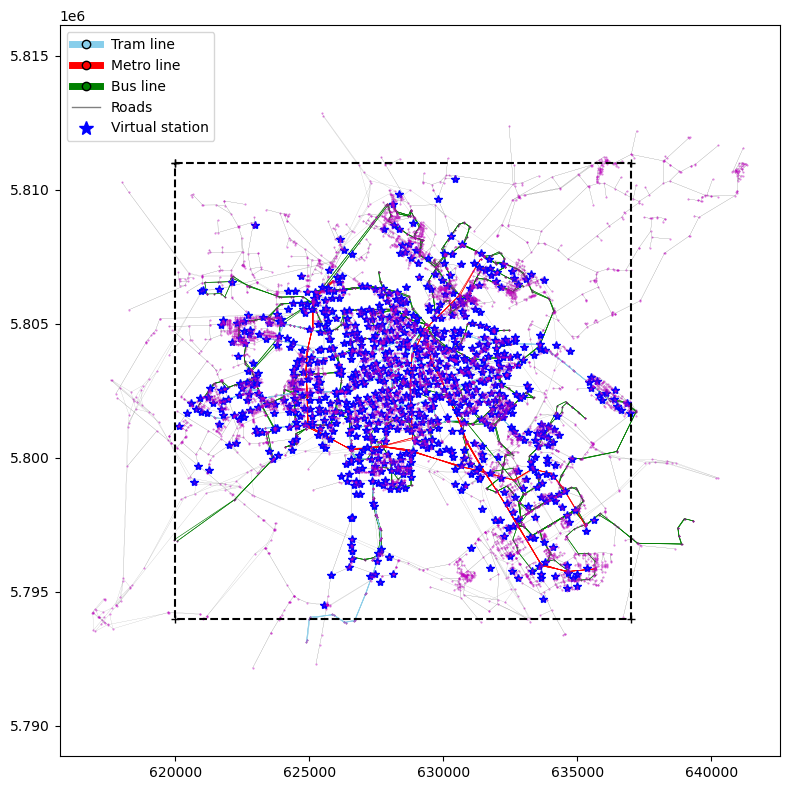

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

plt.plot(x_st, y_st, '*b')

plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

"""for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)"""

#plt.plot([o_user[0], d_user[0]], [o_user[1], d_user[1]], 'o-')
x=list(polygon[:,0])
x.append(polygon[0,0])
y=list(polygon[:,1])
y.append(polygon[0,1])
plt.plot(x, y, '+--k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads'),
          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
            label='Virtual station')]

legend = plt.legend(handles=legend)
#plt.savefig(params['figdir']+'network.pdf')
#plt.xlim([627000,628000])
#plt.ylim([5.8095e6, 5.8105e6])

## Modes shares

In [14]:
def emoped_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return 'emoped1' in modes

def pt_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('BUS' in modes) or ('TRAM' in modes) or ('METRO' in modes)

def calculate_mode_shares(df_paths, list_id):
    emoped_only = 0
    pt_only = 0
    combined = 0
    for id in list_id[:]:
        paths = df_paths[df_paths['ID']==id]
        path = paths.iloc[-1]
        modes = path['SERVICES']
        if emoped_in_modes(modes):
            if pt_in_modes(modes):
                combined+=1
            if (not pt_in_modes(modes)):
                emoped_only+=1
        else:
                pt_only+=1
    sum = len(list_id)
    return (emoped_only/sum, pt_only/sum, combined/sum)

In [15]:
list_id = df_path['ID'].unique()

print(calculate_mode_shares(df_path, list_id))

(0.015333567945301895, 0.9649590266954904, 0.01970740535920768)


In [16]:
#(0.02865761689291101, 0.9482151835093011, 0.023127199597787834)
#(0.03167420814479638, 0.9446958270487682, 0.023629964806435394)


## TTT/TTD

In [17]:
def calculate_tt_td(list_id, df_users):
    TTT = 0
    TTD = 0
    count = 0
    for id in list_id:
        df = df_users[df_users['ID']==id]
        if len(df)>0:
            TTT += Time(df['TIME'].iloc[-1]).to_seconds() - Time(df['TIME'].iloc[0]).to_seconds()
            TTD += df['DISTANCE'].iloc[-1]
            count += 1
    return (TTT/60/count, TTD*1e-3/count)

In [18]:
# Compute total travel time/distance

print(calculate_tt_td(list_id, df_users))

(2.789875801891923, 0.24306907312166587)


In [19]:
df_emoped1[df_emoped1.STATE!='STOP']

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
600,16:01:00.00,36,Bike,EMOPEDLayer1_m1615543977 EMOPEDLayer1_m46449160,626274.422 5805488.808,7.0,SERVING,420.000,6576.0
601,16:01:00.00,202,Bike,EMOPEDLayer1_m46312415 EMOPEDLayer1_m46309912,630764.354 5802205.775,7.0,SERVING,420.000,49246.0
602,16:02:00.00,36,Bike,EMOPEDLayer1_m46437472 EMOPEDLayer1_m297096566,626286.718 5805071.005,7.0,SERVING,840.000,6576.0
606,16:02:00.00,536,Bike,EMOPEDLayer1_m46525705 EMOPEDLayer1_m46521938,628759.742 5807864.540,7.0,SERVING,420.000,196084.0
607,16:03:00.00,36,Bike,EMOPEDLayer1_m297096566 EMOPEDLayer1_m46418359,625954.623 5804851.621,7.0,SERVING,1260.000,6576.0
...,...,...,...,...,...,...,...,...,...
1747,18:03:00.00,507,Bike,EMOPEDLayer1_m1332084350 EMOPEDLayer1_m46379864,626448.774 5803953.198,7.0,SERVING,3352.186,114761.0
1748,18:04:00.00,370,Bike,EMOPEDLayer1_m595462705 EMOPEDLayer1_m46365350,626051.335 5803623.613,7.0,SERVING,1613.234,6633.0
1750,18:04:00.00,507,Bike,EMOPEDLayer1_m1332084350 EMOPEDLayer1_m46379864,626044.819 5803838.217,7.0,SERVING,3772.186,114761.0
1751,18:05:00.00,370,Bike,EMOPEDLayer1_m46364818 EMOPEDLayer1_m1978342133,626099.009 5803266.910,7.0,SERVING,2033.234,6633.0


## Emoped usage

In [20]:
def calculate_emoped_indicators(df_emoped):
    list_emoped = df_emoped['ID'].unique()
    TTD = 0
    TTT = 0
    nb_rides = 0
    for id in list_emoped:
        df = df_emoped[df_emoped['ID']==id]
        TTD += df['DISTANCE'].iloc[-1]
        
        nb_rides_loc = sum(df.STATE=='STOP')-1
        nb_rides += nb_rides_loc
        i_stops = np.where(df.STATE=='STOP')[0]
        for i in range(nb_rides_loc):
            i_start = i_stops[i]+1
            i_stop = i_stops[i+1]
            TTT += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start])
    return (TTD*1e-3, TTT/3600, nb_rides)

def str_to_time(time_str):
    return sum([float(t)*60**(2-i) for i,t in enumerate(time_str.split(':'))])

In [21]:
ttd, ttt, nb_rides = calculate_emoped_indicators(df_emoped1)

In [22]:
rev = 1*nb_rides + 0.33*ttt*60

In [23]:
print(ttd, ttt, nb_rides, rev)

380.6123950000003 12.166666666666666 445 685.9


In [24]:
df = df_emoped1[(df_emoped1.ID==354)]# & (df_emoped1.STATE=='STOP')]
nb_rides = sum(df.STATE=='STOP')-1
tt=0
i_stops = np.where(df.STATE=='STOP')[0]
for i in range(nb_rides):
    i_start = i_stops[i]+1
    i_stop = i_stops[i+1]
    tt += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start])
    print(i,tt)

0 360.0
1 780.0


In [25]:
df

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
245,15:59:00.00,354,Bike,NaN,625565.544 5800885.014,5.5,STOP,0.000,NaN
611,16:03:00.00,354,Bike,EMOPEDLayer1_m46263141 EMOPEDLayer1_m46263072,625471.326 5800824.827,7.0,SERVING,420.000,104184.0
627,16:04:00.00,354,Bike,EMOPEDLayer1_m46279258 EMOPEDLayer1_m46285714,625474.974 5801233.048,7.0,SERVING,840.000,104184.0
644,16:05:00.00,354,Bike,EMOPEDLayer1_m46285785 EMOPEDLayer1_m5191247970,625598.874 5801526.790,7.0,SERVING,1260.000,104184.0
660,16:06:00.00,354,Bike,EMOPEDLayer1_m178873238 EMOPEDLayer1_m178873237,625388.696 5801741.537,7.0,SERVING,1680.000,104184.0
676,16:07:00.00,354,Bike,EMOPEDLayer1_m46314364 EMOPEDLayer1_m46318922,625359.572 5802145.162,7.0,SERVING,2100.000,104184.0
693,16:08:00.00,354,Bike,EMOPEDLayer1_m46336542 EMOPEDLayer1_m46337905,625332.225 5802719.147,7.0,SERVING,2520.000,104184.0
710,16:09:00.00,354,Bike,EMOPEDLayer1_m46348134 EMOPEDLayer1_m46348610,625321.614 5803007.091,7.0,STOP,2808.373,NaN
759,16:11:00.00,354,Bike,EMOPEDLayer1_m46332607 EMOPEDLayer1_m46331848,625331.420 5802596.811,7.0,SERVING,3228.373,105586.0
783,16:12:00.00,354,Bike,EMOPEDLayer1_m46329410 EMOPEDLayer1_m46320223,625350.235 5802360.784,7.0,SERVING,3648.373,105586.0


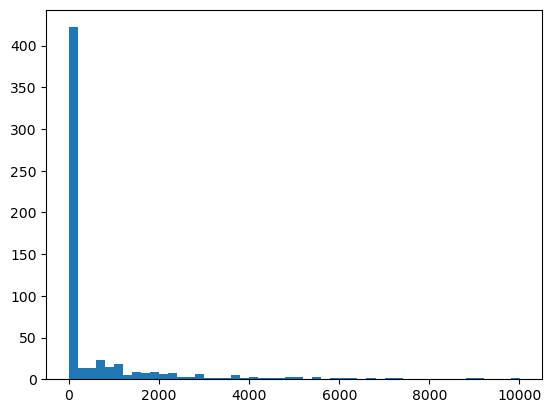

In [26]:
list_emoped = df_emoped1['ID'].unique()
d = []
for id in list_emoped:
    df = df_emoped1[df_emoped1['ID']==id]
    d.append(df['DISTANCE'].iloc[-1])
plt.hist(d, bins=50);

In [27]:
sum([d_==0 for d_ in d])

422

In [28]:
x = []
y = []
x0 = []
y0 = []
list_emoped = df_emoped1['ID'].unique()
TTD = 0
for id in list_emoped:
    df = df_emoped1[df_emoped1['ID']==id]
    p = [float(c) for c in df.POSITION.iloc[-1].split(' ')]
    x.append(p[0])
    y.append(p[1])
    p = [float(c) for c in df.POSITION.iloc[0].split(' ')]
    x0.append(p[0])
    y0.append(p[1])

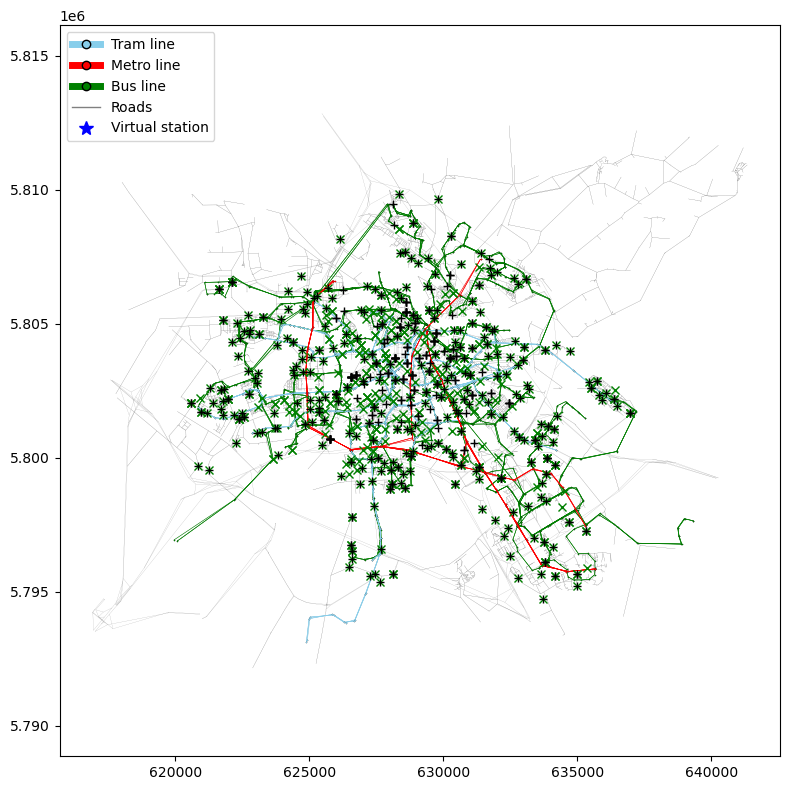

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

#plt.plot(x_st, y_st, '*b')

#plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

"""for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)"""

plt.plot(x0, y0, 'xg')
plt.plot(x, y, '+k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads'),
          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
            label='Virtual station')]

legend = plt.legend(handles=legend)
#plt.savefig(params['figdir']+'network.pdf')
#plt.xlim([627000,628000])
#plt.ylim([5.8095e6, 5.8105e6])

## Station evolution

In [30]:
df_emoped1

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,599,Bike,NaN,636414.650 5802510.894,5.5,STOP,0.0,NaN
1,15:59:00.00,598,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
2,15:59:00.00,597,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
3,15:59:00.00,596,Bike,NaN,632643.138 5806724.043,5.5,STOP,0.0,NaN
4,15:59:00.00,595,Bike,NaN,630266.115 5808261.944,5.5,STOP,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1770,18:21:00.00,294,Bike,NaN,628631.690 5804125.343,5.5,STOP,0.0,NaN
1771,18:21:00.00,471,Bike,NaN,628498.828 5802941.752,5.5,STOP,0.0,NaN
1772,18:21:00.00,569,Bike,NaN,629362.045 5802462.539,5.5,STOP,0.0,NaN
1773,18:21:00.00,472,Bike,NaN,628180.427 5802908.114,5.5,STOP,0.0,NaN


In [31]:
df_emoped1.POSITION == '635811.252 5802339.273'

0       False
1       False
2       False
3       False
4       False
        ...  
1770    False
1771    False
1772    False
1773    False
1774    False
Name: POSITION, Length: 1775, dtype: bool

In [32]:
df_stations['position'] = df_stations.apply(lambda row: '%.3f %.3f'%(row.x_node, row.y_node), axis=1)

In [33]:
df_stations.position

0      620422.006 5801655.356
1      620921.199 5802237.763
2      620575.799 5802043.732
3      620143.643 5801202.518
4      621785.068 5801591.686
                ...          
800    632571.149 5806957.045
801    632643.138 5806724.043
802    631772.347 5806813.012
803    628722.734 5807971.700
804    636414.650 5802510.894
Name: position, Length: 805, dtype: object

In [34]:
station_emoped = np.zeros((len(df_stations), df_stations.nb_emoped.sum()))
nb_emoped_stations = np.zeros((len(df_emoped1.TIME.unique()), len(df_stations)), int)
for i_t, t in enumerate(df_emoped1.TIME.unique()):
    df = df_emoped1[df_emoped1.TIME==t]
    df2 = df[df.STATE=='STOP']
    for i,row in df2.iterrows():
        i_sta = df_stations.index[df_stations.position==row.POSITION][0]
        station_emoped[:, row.ID] = 0
        station_emoped[i_sta, row.ID] = 1
    df3 = df[df.STATE!='STOP']
    for i,row in df3.iterrows():
        station_emoped[:, row.ID] = 0
    nb_emoped_stations[i_t] = station_emoped.sum(axis=1)
    

In [35]:
df_stations.index[df_stations.position==row.POSITION][0]

565

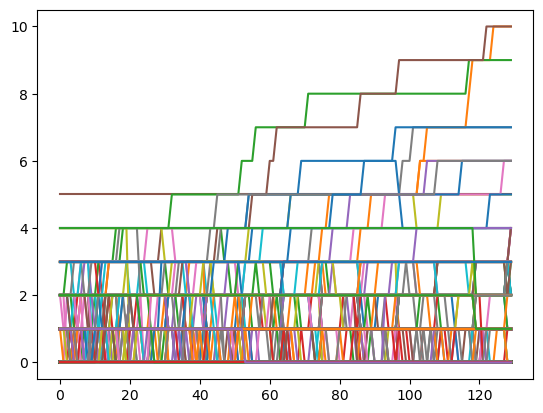

In [36]:
plt.plot(nb_emoped_stations);
#plt.ylim([0,5])

In [37]:
df_emoped1

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,599,Bike,NaN,636414.650 5802510.894,5.5,STOP,0.0,NaN
1,15:59:00.00,598,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
2,15:59:00.00,597,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
3,15:59:00.00,596,Bike,NaN,632643.138 5806724.043,5.5,STOP,0.0,NaN
4,15:59:00.00,595,Bike,NaN,630266.115 5808261.944,5.5,STOP,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1770,18:21:00.00,294,Bike,NaN,628631.690 5804125.343,5.5,STOP,0.0,NaN
1771,18:21:00.00,471,Bike,NaN,628498.828 5802941.752,5.5,STOP,0.0,NaN
1772,18:21:00.00,569,Bike,NaN,629362.045 5802462.539,5.5,STOP,0.0,NaN
1773,18:21:00.00,472,Bike,NaN,628180.427 5802908.114,5.5,STOP,0.0,NaN


In [38]:
nb_emoped_stations[-1,:].sum()

600

In [39]:
nb_emoped_stations[:10,:10]

array([[0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 0, 3, 0, 1, 0, 1, 1, 1, 2]])